# Inception-Net-V3 Notebook

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
import sys

## Contents

### Directories

In [2]:
# go to parent directory
os.chdir("..")
import paths

REPO_DIR = paths.get_repo_path()
ROOT_DIR = REPO_DIR / "Stanford Dogs"
DATA_BASE_PATH = paths.get_data_path() / "stanford-dogs-dataset"
DATA_PATH = DATA_BASE_PATH / "splited-data"

TRAIN_PATH = DATA_PATH / "train"
TEST_PATH = DATA_PATH / "test"

# set path to repo_dir
os.chdir(REPO_DIR)

## Data

### Variables

In [3]:
RANDOM_SEED = 42
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

VALIDATION_SPLIT = 0.2

BATCH_SIZE = 64

CLASS_NAMES = sorted([img_cls for img_cls in  os.listdir(TRAIN_PATH) if img_cls != ".DS_Store"])
NUM_CLASSES = len(CLASS_NAMES)

# MODEL
MODEL_PATH = ROOT_DIR / "models"
LOG_PATH = ROOT_DIR / "log"



In [4]:
tf.random.set_seed(RANDOM_SEED)

### Data Augmentation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1./255,
    
    horizontal_flip=True,
    
    rotation_range=20,
    
    height_shift_range=0.1,       # No need to shift the image
    width_shift_range=0.1,
    zoom_range=0.1,
    
    shear_range=0.1,              # Seems to be useful
    
    validation_split=VALIDATION_SPLIT,
)

val_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    )

test_generator = ImageDataGenerator(
    rescale=1./255,
)

In [6]:
train_images = train_generator.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    
    shuffle=True,
    seed=42,
    
    subset='training',
)

val_images = val_generator.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    
    shuffle=True,
    seed=42,
    
    subset='validation'
)


test_images = test_generator.flow_from_directory(
    TEST_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    
    batch_size=BATCH_SIZE,
    
    shuffle=True,
    seed=42,
)

NUM_TRAIN_IMAGES = len(train_images.filenames)
NUM_VAL_IMAGES = len(val_images.filenames)
NUM_TEST_IMAGES = len(test_images.filenames)

Found 12369 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.
Found 5186 images belonging to 120 classes.


### LOADING DATA

In [114]:
from sklearn.preprocessing import LabelEncoder

def give_class_name(y:np.ndarray) -> np.ndarray:
    if len(y.shape) == 2:
        y = y.argmax(axis=1)
    enc = LabelEncoder().fit(CLASS_NAMES)
    y_labeled = enc.inverse_transform(y)
    
    return y_labeled

# display images in a grid function
def display_image_grid(images, labels, pred_val=None,shape=(5, 5), figsize=(10, 10)):
    plt.figure(figsize=figsize)
    m = shape[0] * shape[1]
    
    if images.shape[0] < m:
        raise ValueError("images.shape[0] must equal shape[0] * shape[1]")
    
    if labels.shape[0] != images.shape[0]:
        raise ValueError("labels.shape[0] must equal images.shape[0]")
    
    if pred_val is not None and pred_val.shape[0] != images.shape[0]:
        raise ValueError("pred_val.shape[0] must equal images.shape[0]")
    
    for i in range(m):
        plt.subplot(shape[0], shape[1], i+1)
        plt.imshow(images[i], cmap="gray", interpolation="none")
        title = labels[i]
        if pred_val is not None:
            title = f"{pred_val[i]}"
            if pred_val[i] != labels[i]:
                title += f"\n({labels[i]})"
        plt.title(title)
        plt.axis("off")
        # increase vertical space between subplots
        plt.subplots_adjust(wspace=0.1, hspace=0.4)
    plt.show()
    

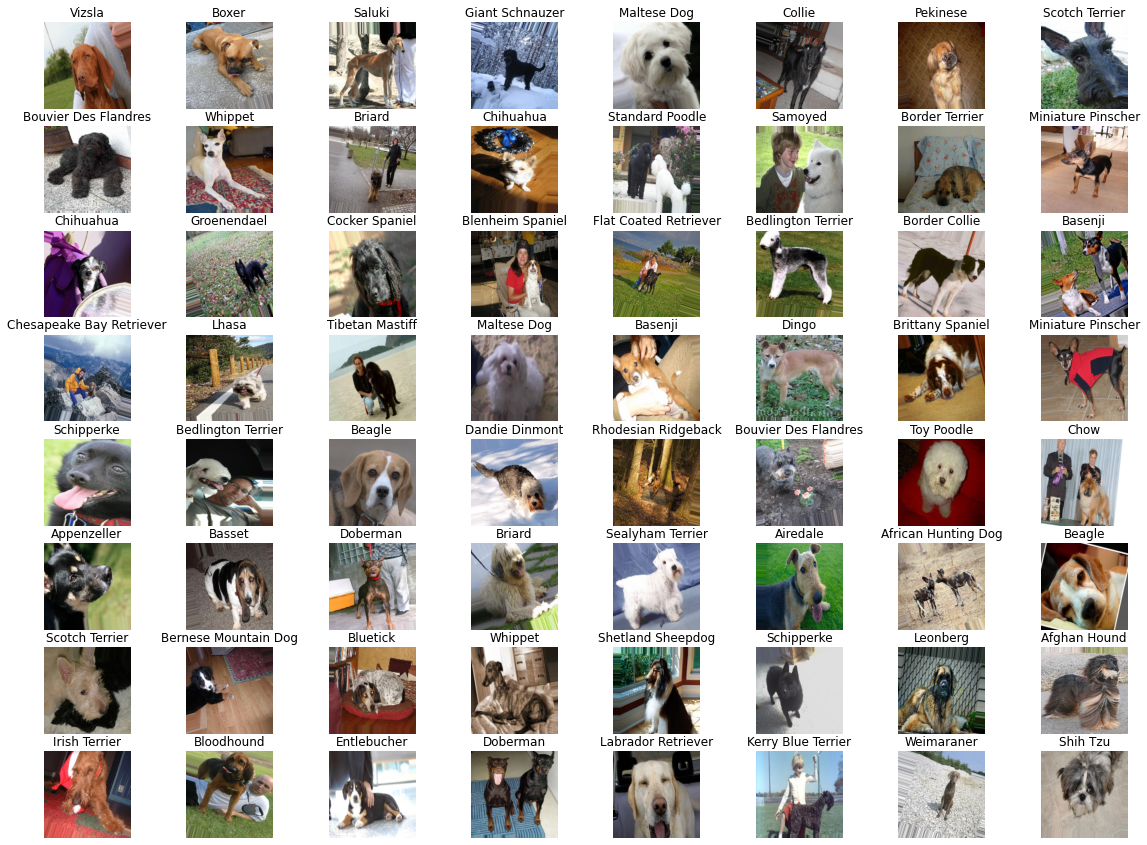

In [7]:
num_rows = 8
num_cols = 8

plt.figure(figsize=(20, 15))

images, labels = train_images.next()
for i in range(num_cols * num_rows):
    plt.subplot(num_cols, num_rows, i + 1)
    plt.imshow(images[i])
    plt.title(CLASS_NAMES[labels[i].argmax()])
    plt.axis('off')

plt.show()

## Model

In [8]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Rescaling, Input, Add, Activation, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score


### Valribles

In [9]:
INPUT_SHAPE = train_images.next()[0][0].shape
TRAIN_MODELS = True
TRAIN_MODELS = False

### Useful functions ###

In [115]:
def predict_label(images, model):
    predictions = model.predict(images)
    return predictions.argmax(axis=1)


# ploting the model training history
def plot_model_performance(history, figsize=(10, 10)):
    preformance = {key: val for key, val in history.history.items() if "loss" not in key}
    losses = {key: val for key, val in history.history.items() if "loss" in key}
    
    plt.figure(figsize=figsize)
    plt.title('Model Performance')
    for key, val in preformance.items():
        plt.plot(val, label=key)
    plt.legend(preformance.keys())
    plt.xlabel('Epoch')
    
    plt.figure(figsize=figsize)
    plt.title('Model Losses')
    for key, val in losses.items():
        plt.plot(val, label=key)
    plt.legend(losses.keys())
    plt.xlabel('Epoch')
    
    plt.show()


def get_model_performance(y_true, y_pred):
    if len(y_true.shape) == 2:
        y_true = y_true.argmax(axis=1)
    if len(y_pred.shape) == 2:
        y_pred = y_pred.argmax(axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    f1_scr = f1_score(y_true, y_pred, average='weighted')
    precision_scr = precision_score(y_true, y_pred, average='weighted')
    recall_scr = recall_score(y_true, y_pred, average='weighted')
    
    performance = {
        "Accuracy": accuracy,
        "F1 Score": f1_scr,
        "Precision": precision_scr,
        "Recall": recall_scr
    }
    
    return performance
    

### MODELS

#### MODEL ARCHITECTURE

In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

model_name = "Inception-net-V3"
weight_decay = 10e-5
LEARNING_RATE = 1e-4
TRAINABLE_CHANCE = 0.1
# weight_decay = 0

# def final_model(tl_model, weight_path, num_classes: int):
#     model = Sequential(name=model_name)

#     old_model = load_model(weight_path)
    
#     for layer in tl_model.layers:
#         layer.trainable = np.random.rand() < TRAINABLE_CHANCE

#     model.add(tl_model)
    
#     for layer in old_model.layers[1:]:
#         model.add(layer)

#     model._name = model_name

#     return model

def final_model(tl_model, num_classes: int):
    
    # tl_model.trainable = False
    for layer in tl_model.layers:
        layer.trainable = np.random.rand() < TRAINABLE_CHANCE

    model = Sequential(name=model_name)
    model.add(tl_model)
    model.add(GlobalAveragePooling2D())
    
    model.add(Dropout(0.3))
    
    model.add(Dense(512, kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Dropout(0.4))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model
    


In [128]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# model_weights_path = MODEL_PATH / f"TL-{model_name}.h5"
tl_model = InceptionV3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

In [131]:
# model = final_model(tl_model, model_weights_path, NUM_CLASSES)
model = final_model(tl_model, NUM_CLASSES)

model.compile(
            optimizer=Adam(lr=LEARNING_RATE),
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                'top_k_categorical_accuracy',
                ]
            )

model.summary()

Model: "Inception-net-V3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_944 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 activation_944 (Activation)  (None, 512)         

#### Model Training

In [132]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger

monitor_metric = 'val_accuracy'

# Early stopping
es = EarlyStopping(
        monitor=monitor_metric,
        patience=5,
        mode = "auto",
        verbose=1,
)

# Learning rate scheduler
def step_decay(epoch):
    initial_lr = LEARNING_RATE
    k = 0.1
    lr = initial_lr * np.exp(-k*epoch)
    return lr

lrd = LearningRateScheduler(step_decay)

# Model Checkpoint
mdl_check = ModelCheckpoint(
        MODEL_PATH / f"{model.name}.h5",
        monitor=monitor_metric,
        save_best_only=True,
        mode='auto',
        verbose=1,
)
        
# CSV Logger
csv_logger = CSVLogger(
        LOG_PATH / f"{model.name}.csv",
        append=False,
)


callbacks = [
        es, 
        lrd,
        mdl_check, 
        # csv_logger,
    ]

In [133]:
train_model = not (os.path.exists(MODEL_PATH / f"{model_name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=20, 
                        callbacks=callbacks,                        
)

Epoch 1/10
194/194 [==============================] - ETA: 0s - loss: 3.6621 - accuracy: 0.2543 - top_k_categorical_accuracy: 0.4717
Epoch 1: val_accuracy improved from -inf to 0.71339, saving model to /home/vineet/.personal/code/Hello-CNN/Stanford Dogs/models/Inception-net-V3.h5
194/194 [==============================] - 73s 364ms/step - loss: 3.6621 - accuracy: 0.2543 - top_k_categorical_accuracy: 0.4717 - val_loss: 1.6738 - val_accuracy: 0.7134 - val_top_k_categorical_accuracy: 0.9322 - lr: 1.0000e-04
Epoch 2/10
194/194 [==============================] - ETA: 0s - loss: 1.7920 - accuracy: 0.6171 - top_k_categorical_accuracy: 0.8774
Epoch 2: val_accuracy improved from 0.71339 to 0.76727, saving model to /home/vineet/.personal/code/Hello-CNN/Stanford Dogs/models/Inception-net-V3.h5
194/194 [==============================] - 70s 358ms/step - loss: 1.7920 - accuracy: 0.6171 - top_k_categorical_accuracy: 0.8774 - val_loss: 1.0790 - val_accuracy: 0.7673 - val_top_k_categorical_accuracy: 0

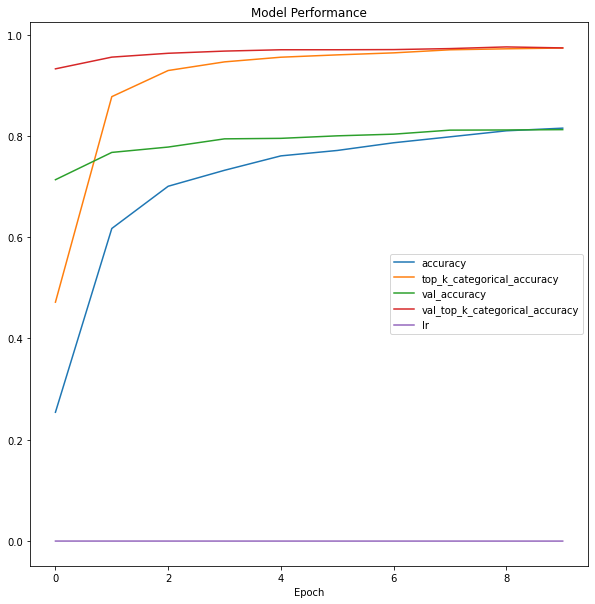

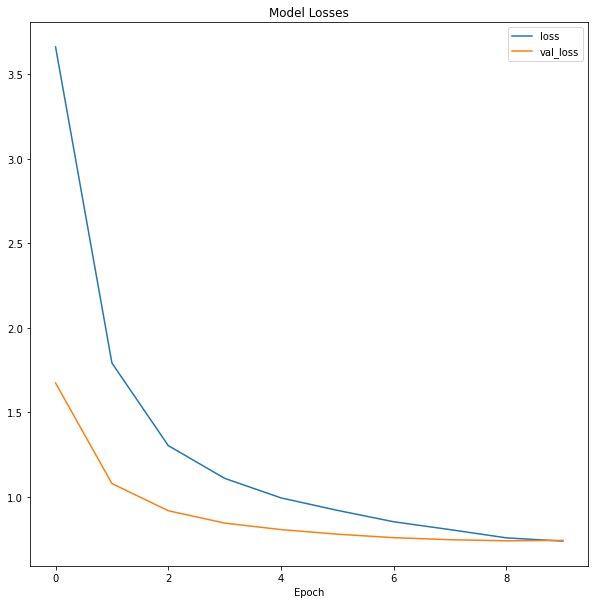

In [134]:
if train_model:
    plot_model_performance(history)

In [135]:
if train_model:
    model.evaluate(test_images)

109/109 [==============================] - 6s 53ms/step - loss: 0.7162 - accuracy: 0.8157 - top_k_categorical_accuracy: 0.9718


In [136]:
from tensorflow.keras.models import load_model
model = load_model(MODEL_PATH / f"{model_name}.h5")
print("Model Loaded")

Model Loaded


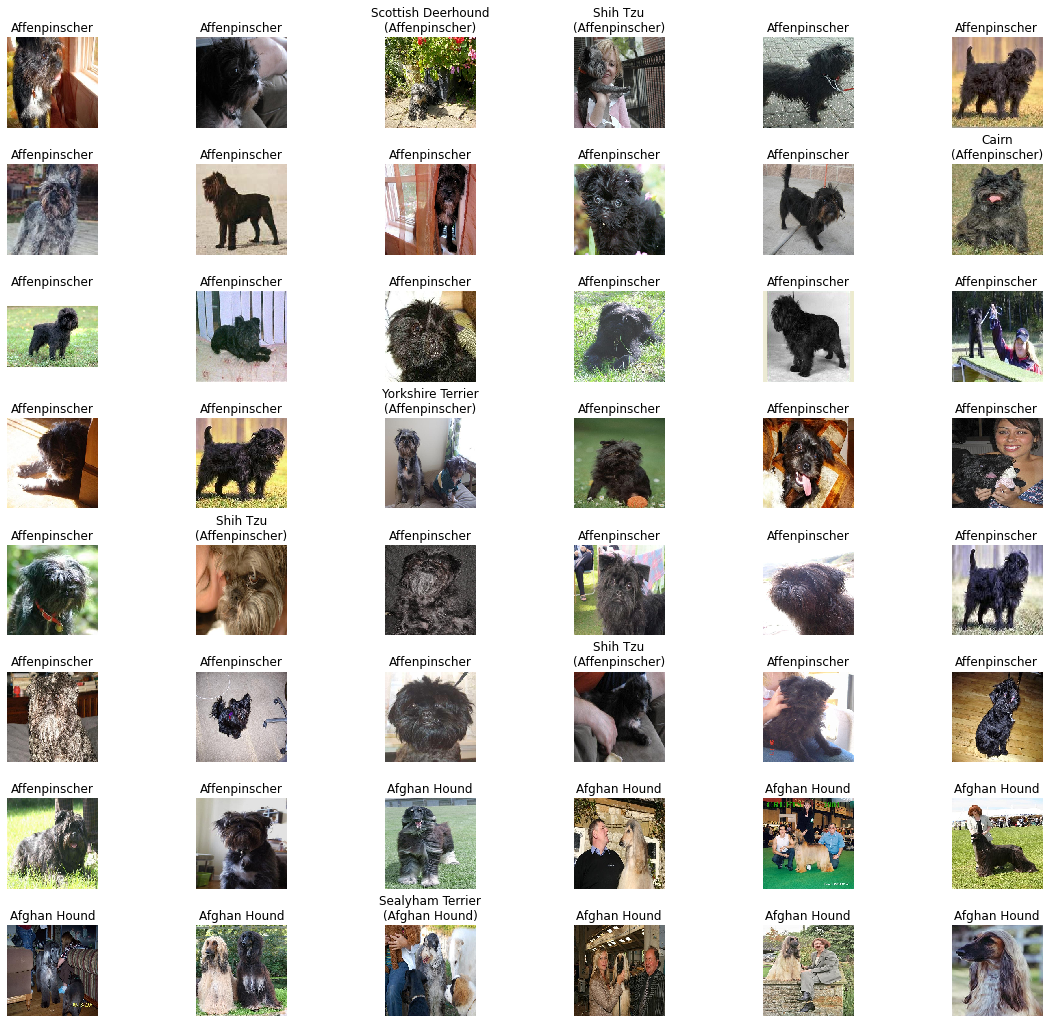

In [137]:
plt_size = (20, 18)

num_rows = 8
num_cols = 6

test_images.batch_size = num_rows * num_cols

images, labels = test_images.next()
labels_pred = predict_label(images, model)

display_image_grid(
                images, 
                give_class_name(labels), give_class_name(labels_pred),
                shape=(num_rows, num_cols),
                figsize=plt_size,
                )

In [138]:
test_images.reset()
test_images.shuffle = False

test_labels = test_images.labels
test_labels_pred = model.predict_generator(test_images).argmax(axis=1)


/tmp/ipykernel_33956/255755682.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_labels_pred = model.predict_generator(test_images).argmax(axis=1)


In [139]:
#  confusion matrix and classification report

performance = get_model_performance(test_labels, test_labels_pred)
print("Score:", performance["Accuracy"])
print(classification_report(test_labels, test_labels_pred))


Score: 0.8156575395295025
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        38
           1       0.96      0.92      0.94        60
           2       0.95      0.91      0.93        43
           3       0.76      0.82      0.79        51
           4       0.70      0.68      0.69        41
           5       0.70      0.50      0.58        38
           6       0.72      0.67      0.69        49
           7       0.78      0.96      0.86        53
           8       0.80      0.84      0.82        44
           9       0.66      0.76      0.70        49
          10       0.96      1.00      0.98        46
          11       0.84      0.89      0.87        55
          12       0.85      0.82      0.84        40
          13       0.88      0.94      0.91        47
          14       0.96      0.91      0.93        47
          15       0.94      0.67      0.78        43
          16       0.68      0.89      0.77        38
 